In [1]:
import torch 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import AfricanWildlifeDataset
from loss import YoloLoss
from YOLOv1 import YOLOv1
from train import train
from test import test
from utils import plot_bbox, get_boxes, non_max_suppression, compute_ap

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 5
EPOCHS = 1
TRAIN_DIR = 'African_Wildlife/train'
TEST_DIR = 'African_Wildlife/test'
LABEL_DIR = 'African_Wildlife/annotations'
S, B, C = 7, 2, 4

## Loading data

In [3]:
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, transform=transform)
train_loader = DataLoader(
    dataset = train_set,
    batch_size = BATCH_SIZE, 
    shuffle = True
)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size= 3, shuffle= False)

## Training

In [4]:
model = YOLOv1(input_channels=3, S=S, B=B, C=C).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss()


In [5]:
train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, load_model=True)


-> Loading checkpoint


100%|██████████| 240/240 [00:33<00:00,  7.11it/s, loss=0.00242]

 EPOCH 1:  Mean loss 0.004


[0.003975008333994386]

## Testing

In [8]:
y_pred = test(test_loader, model)

In [9]:
print(y_pred.size())

torch.Size([304, 49, 6])


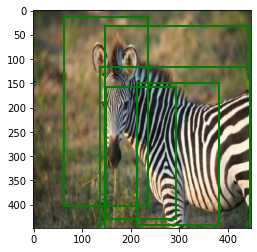

In [12]:
idx = 15
bbx = y_pred[idx, y_pred[idx, ::, 1] > 0]
plot_bbox(idx, test_set, bbx)

# MAP 

In [13]:
import torch
from utils import cellboxes_to_boxes, intersection_over_union
from test import filter_predictions


def new_test(test_loader, model, DEVICE='cuda', prob_thresh=0.6):
    model.eval()
    predictions_by_batch = []
    gt_by_batch = []
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x) 
        # reshaping and converting coordinates
        output = torch.tensor(cellboxes_to_boxes(output))
        ground_truths = torch.tensor(cellboxes_to_boxes(y))

        # sigmoid on probabilities
        torch.sigmoid_(output[..., 1])
        predictions_by_batch.append(output)
        gt_by_batch.append(ground_truths) 

    y_pred = torch.cat(tuple(predictions_by_batch))
    y_pred = filter_predictions(y_pred, prob_thresh)
    y_true = torch.cat(tuple(gt_by_batch))

    return y_pred, y_true


In [14]:
y_predd, y_truee = new_test(test_loader, model)

In [15]:
print(y_predd.size()) 
print(y_truee.size()) 

torch.Size([304, 49, 6])
torch.Size([304, 49, 6])


In [21]:
from utils import intersection_over_union
def nms(predictions, iou_threshold=0.5): 
    
    """
    Implements Non Max Suppression 
    
    Input: 
        predictions(tensor): bounding box predictions for an image
        iou_threshold(float): iou threshold 
    
    """
    
    # predictions: (49, 6) 
    bboxes = predictions.tolist() 
    
    # We sort the bound_boxes in reverse order according to confidence score
    sorted_bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) 
    
    # We remove all the empty boxes
    candidates = [box for box in sorted_bboxes if box[1] != 0]
    
    num_candidates = len(candidates) 
    keep={idx:True for idx, box in enumerate(candidates)} 
    # True: if we keep it 
    # False: if we remove it  
    
    # we compare each image (that is set to True) with the rest
    # and remove the ones that overlap
    for i in range(num_candidates):
        for j in range(i+1, num_candidates): 
            if keep[i]:
                if candidates[i][0] == candidates[j][0]: # they have the same class
                    boxes_iou = intersection_over_union(torch.tensor(candidates[i][2:]), torch.tensor(candidates[j][2:]))
                    if boxes_iou > iou_threshold: 
                        keep[j] = False
        
    keep_boxes = [k for k, v in keep.items() if v]
    nms = [candidates[i] for i in keep_boxes]
    
    return nms
    

In [18]:
def get_boxes2(y_pred, y_true, threshold=0.1): 
    
    """
        Prepares the predictions and ground truths for mAP
        
        Input: 
            y_pred(tensor): torch.size([num_images, num_cells, bounding box])  
            y_true(tensor): torch.size([num_images, num_cells, bounding box]) 
            threshold(float): filter out the 0 pred
            
        Output: 
            all_pred_boxes(list): [ [image_idx, c, p, x, y, w, h], [], ...]
            all_true_boxes(list): [ [image_idx, c, p, x, y, w, h], [], ...]
    
    """

    batch_size = y_pred.shape[0]
    #bound_boxes = y_pred.tolist() # [ [], [], []] 
    true_boxes = y_true.tolist()
    image_idx = 0 # label that determines the image 
    all_pred_boxes = []
    all_true_boxes = []
    
    for idx in range(batch_size): 
        nms_boxes = nms(y_pred[idx]) 

        for nms_box in nms_boxes: 
            if nms_box[2:] != [0, 0, 0, 0]: # to remove the boxes with only zeroes
                all_pred_boxes.append([image_idx] + nms_box) 
        
        for box in true_boxes[idx]: 
            if box[1] > threshold: # to remove the boxes with only zeroes
                all_true_boxes.append([image_idx] + box) 
            
        image_idx += 1
        
    return all_pred_boxes, all_true_boxes

In [22]:
pred_boxes, true_boxes = get_boxes2(y_predd, y_truee) 

In [23]:
print(len(pred_boxes))
print(len(true_boxes))

386
501


In [24]:
mean_average_precision = compute_ap(pred_boxes, true_boxes)
print(mean_average_precision)

tensor(0.0024)
